<a href="https://colab.research.google.com/github/pedroasgDEV/CCO-Evolutionary-Optimization/blob/master/trabalho_comp_evolutiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
import math
import random
import deap
import numpy as np

# Uso de Computação Evolutiva para a Otimização Geométrica do Método CCO


**Autor:** *Pedro Augusto Sousa Gonçalves*

**E-mail:** *pedro.asg@aluno.ufop.edu.br*

# 1. Introdução

## 1.1 Método CCO

O método CCO permite a geração de árvores arteriais em domínios 2D e 3D **[1, 3]**. Ele se baseia na adição sucessiva de segmentos dentro de uma área de perfusão, realizando a cada nova adição uma otimização geométrica da bifurcação gerada, com o objetivo de minimizar o volume intravascular total da árvore. Essa abordagem resulta em uma estrutura vascular otimizada, projetada para simular redes arteriais reais **[2]**.

Embora o método CCO seja o estado da arte na modelagem de árvores arteriais, o algoritmo apresentado em **[1]** e **[3**] utiliza uma otimização baseada em gradiente, o que aumenta significativamente a probabilidade de convergir para mínimos locais, potencialmente limitando a qualidade da solução globalmente ótima.


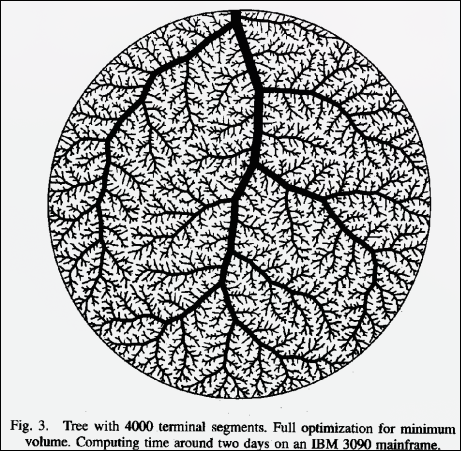

## 1.2 Descrição do problema

Dada uma árvore arterial 2D com uma bifurcação e com 3 segmentos, sendo um o pai, saindo do ponto de perfusão, os outros dois são segmentos terminais. O problema consiste em encontrar um ponto no plano cartesiano para a bifurcação em que o volume intravascular total da árvore seja o menor possível. Para tal, serão utilizados os limites cartesianos apresentados em **[2]** para encontrar o ponto ótimo para a bifurcação.

## 1.3 Objetivos

Encontrar um ponto em um plano cartesiano para a bifurcação em que o volume intravascular total da árvore arterial seja o menor possível e em menor que o algoritmo classico de otimização baseada em gradiente.

# 2. Fundamentação Teórica


Para calcular o volume intravascular total da árvore, deverá ser usada a seguinte equação:

\begin{equation}\label{EQ: volume intravascular}
        V = \pi \sum_{i=1}^{K_{\text{tot}}} l_i r^2_i
\end{equation}

sendo $ k_{\textit{tot}} $ o número total de segmentos, $l_i$ e $r_i$ são respectivamente o comprimento e o raio do segmento $ i $.

In [109]:
def calcVolume(segmentos: list[dict]) -> float:
    volume = 0.0
    for seg in segmentos:
      volume += seg['comprimento'] * seg['raio']**2

    return volume * math.pi

Para tal, será necessário calcular o comprimento e o raio dos segmentos. Inicialmente deve se calcular o comprimento a partir da seguinte equação:

\begin{equation}\label{EQ: comprimento do segmento}
        L_a = \sqrt{(X_p - X_b)^2 + (Y_p - Y_b)^2},
        L_b = \sqrt{(X_f^1 - X_b)^2 + (Y_f^1 - Y_p)^2},
        L_c = \sqrt{(X_f^2 - X_b)^2 + (Y_f^2 - Y_p)^2}
\end{equation}

In [ ]:
def calcComprimento(begin: list[float], end: list[float]) -> float:
    return np.linalg.norm(np.subtract(begin, end)) # Calcula a norma euclidiana (distância entre pontos).

Para encontrar os raios dos segmentos deve se seguir alguns passos para encontrá-los. Inicialmente deve se calcular a resistência hidrodinâmica relativa ($R*$) de cada segmento, que é uma versão reduzida da resistência hidrodinâmica ($R$), que é dada pela lei de Poiseuille [1]. Para encontrar ($R*$) deve se utilizar a seguinte equação:

\begin{equation}\label{EQ: Resistência hidrodinâmica}
        R_i = \left( \frac{8 \eta}{\pi} \right) \frac{l_i}{r^4_i}
\end{equation}

\begin{equation}\label{EQ: Resistência hidrodinâmica Relativa}
        R_i* = R_i {r^4_i},
        R_i* = \left( \frac{8 \eta}{\pi} \right) l_i
\end{equation}

Em que $ \eta $ representa a viscosidade sanguínea ($ \eta = 3.6 cP$).

In [ ]:
def calcResistenciaRelativa(comprimento: float, viscosidade: float = 0.0036) -> float:
    return (8 * viscosidade) / (math.pi * comprimento)

def CalcResistencia(resistenciaRelativa: float, raio: float) -> float:
    return resistenciaRelativa * raio**4

Após, deve-se calcular o raio relativo do segmento B e C $ (\frac{r_b}{r_c}$), que podem ser encontrados pela equação:

\begin{equation}\label{EQ: Raio Relativo}
        \frac{r_b}{r_c} = (\frac{R_b*}{R_c*})^\frac{1}{4}
\end{equation}


In [ ]:
def calcRaioRelativo(resistenciaRelativa_esq: float, resistenciaRelativa_dir: float) -> float:
  return (resistenciaRelativa_esq / resistenciaRelativa_dir)**(1/4)

Tendo os raios relativos é possível calcular a razão da bifurcação dos segmentos filhos de A ($ \beta^{esq}_a $ e $ \beta^{dir}_a $) pela equação:

\begin{equation}\label{EQ: bifurcação relativa}
    \beta^{dir}_a = [1 + (\frac{r_b}{r_c})^\gamma]^{-\frac{1}{\gamma}},
    \beta^{esq}_a = [1 + (\frac{r_b}{r_c})^{-\gamma}]^{-\frac{1}{\gamma}}
\end{equation}

Em que o expoente $ \gamma $ que é a constante de bifurcação ($ \gamma \in [2.55;3] $).

In [ ]:
def calcRazaoBirfucacao_dir(raioRelativo: float,  gamma: float = 3.0) -> float:
    return (1 + raioRelativo **gamma) **(-1/gamma)

def calcRazaoBirfucacao_esq(raioRelativo: float, gamma: float = 3.0) -> float:
    return (1 + raioRelativo **(-gamma)) **(-1/gamma)

Apos calcular a razão de bifurcação dos segmentos filhos de A pode se calcular a resistência hidrostática relativa da árvore, para isso será usado a seguinte equação:

\begin{equation}\label{EQ: resistencia arvore}
    R^*_{\textit{sub a}} = R^*_a + \left[ \frac{(\beta^{esq}_a)^4}{R^*_{\textit{b}}} + \frac{(\beta^{dir}_a)^4}{R^*_{\textit{c}}} \right]^{-1}
\end{equation}

In [ ]:
def calcResistenciaRelativa_sub(resistenciaRelativa_pai: float, resistenciaRelativa_esq: float, resistenciaRelativa_dir: float,
                               razaoBirfucacao_esq: float, razaoBirfucacao_dir: float) -> float:
    razao_esq = razaoBirfucacao_esq**4/resistenciaRelativa_esq
    razao_dir = razaoBirfucacao_esq**4/resistenciaRelativa_dir
    return resistenciaRelativa_pai + (razao_esq + razao_dir)**(-1)

Tendo a resistência hidrostática relativa da árvore, pode-se calcular o raio de A ($r_a$) a partir da seguinte equação:

\begin{equation}\label{EQ: raio raiz}
    r_a = (R^*_{\textit{sub a}} \frac{Q_{\textit{perf}}}{P_{\textit{perf}} - P_{\textit{term}}}) ^ {\frac{1}{4}}
\end{equation}

Sendo $ Q_{\textit{perf}} $ o fluxo de entrada, $ P_{\textit{perf}} $ a pressão de entrada e $ P_{\textit{term}} $ a pressão de saida.

In [ ]:
def calcRaio_pai(resistenciaRelativa_sub: float, pressaoDiff: float, fluxo: float) -> float:
    return (resistenciaRelativa_sub * fluxo/pressaoDiff) **(1/4)

Apos encontrar o $r_a$ é possivel calcular o raios dos proximos segmentos usando as equações.

\begin{equation}\label{EQ: raios restantes}
    \beta^{dir}_a = \frac{r_c}{r_a},
    \beta^{esq}_a = \frac{r_b}{r_a}
\end{equation}

In [ ]:
def calcRaio_dir(raio_pai: float, razaoBirfucacao_dir: float) -> float:
    return razaoBirfucacao_dir * raio_pai

def calcRaio_esq(raio_pai: float, razaoBirfucacao_esq: float) -> float:
    return razaoBirfucacao_esq * raio_pai


# 3. Materiais e Métodos

## 3.1 Estrutura da Árvore

Como o objetivo desse trabalho é validar uma solução evolutiva para a otimização geometrica do método CCO, a árvore 2D a ser gerada tera somente 3 segmentos, com o ponto de perfusão e os dois pontos terminais fixos, variando somente o ponto de bifurcação. O poto de perfusão será $ Point_{perf}(0, 5)$ e os pontos terminais serão $ Point_{term}esq(-3.54, -1.46)$ e $ Point_{term}dir(3.54, -1.46)$, o $Point_{birf}$ irá variar.

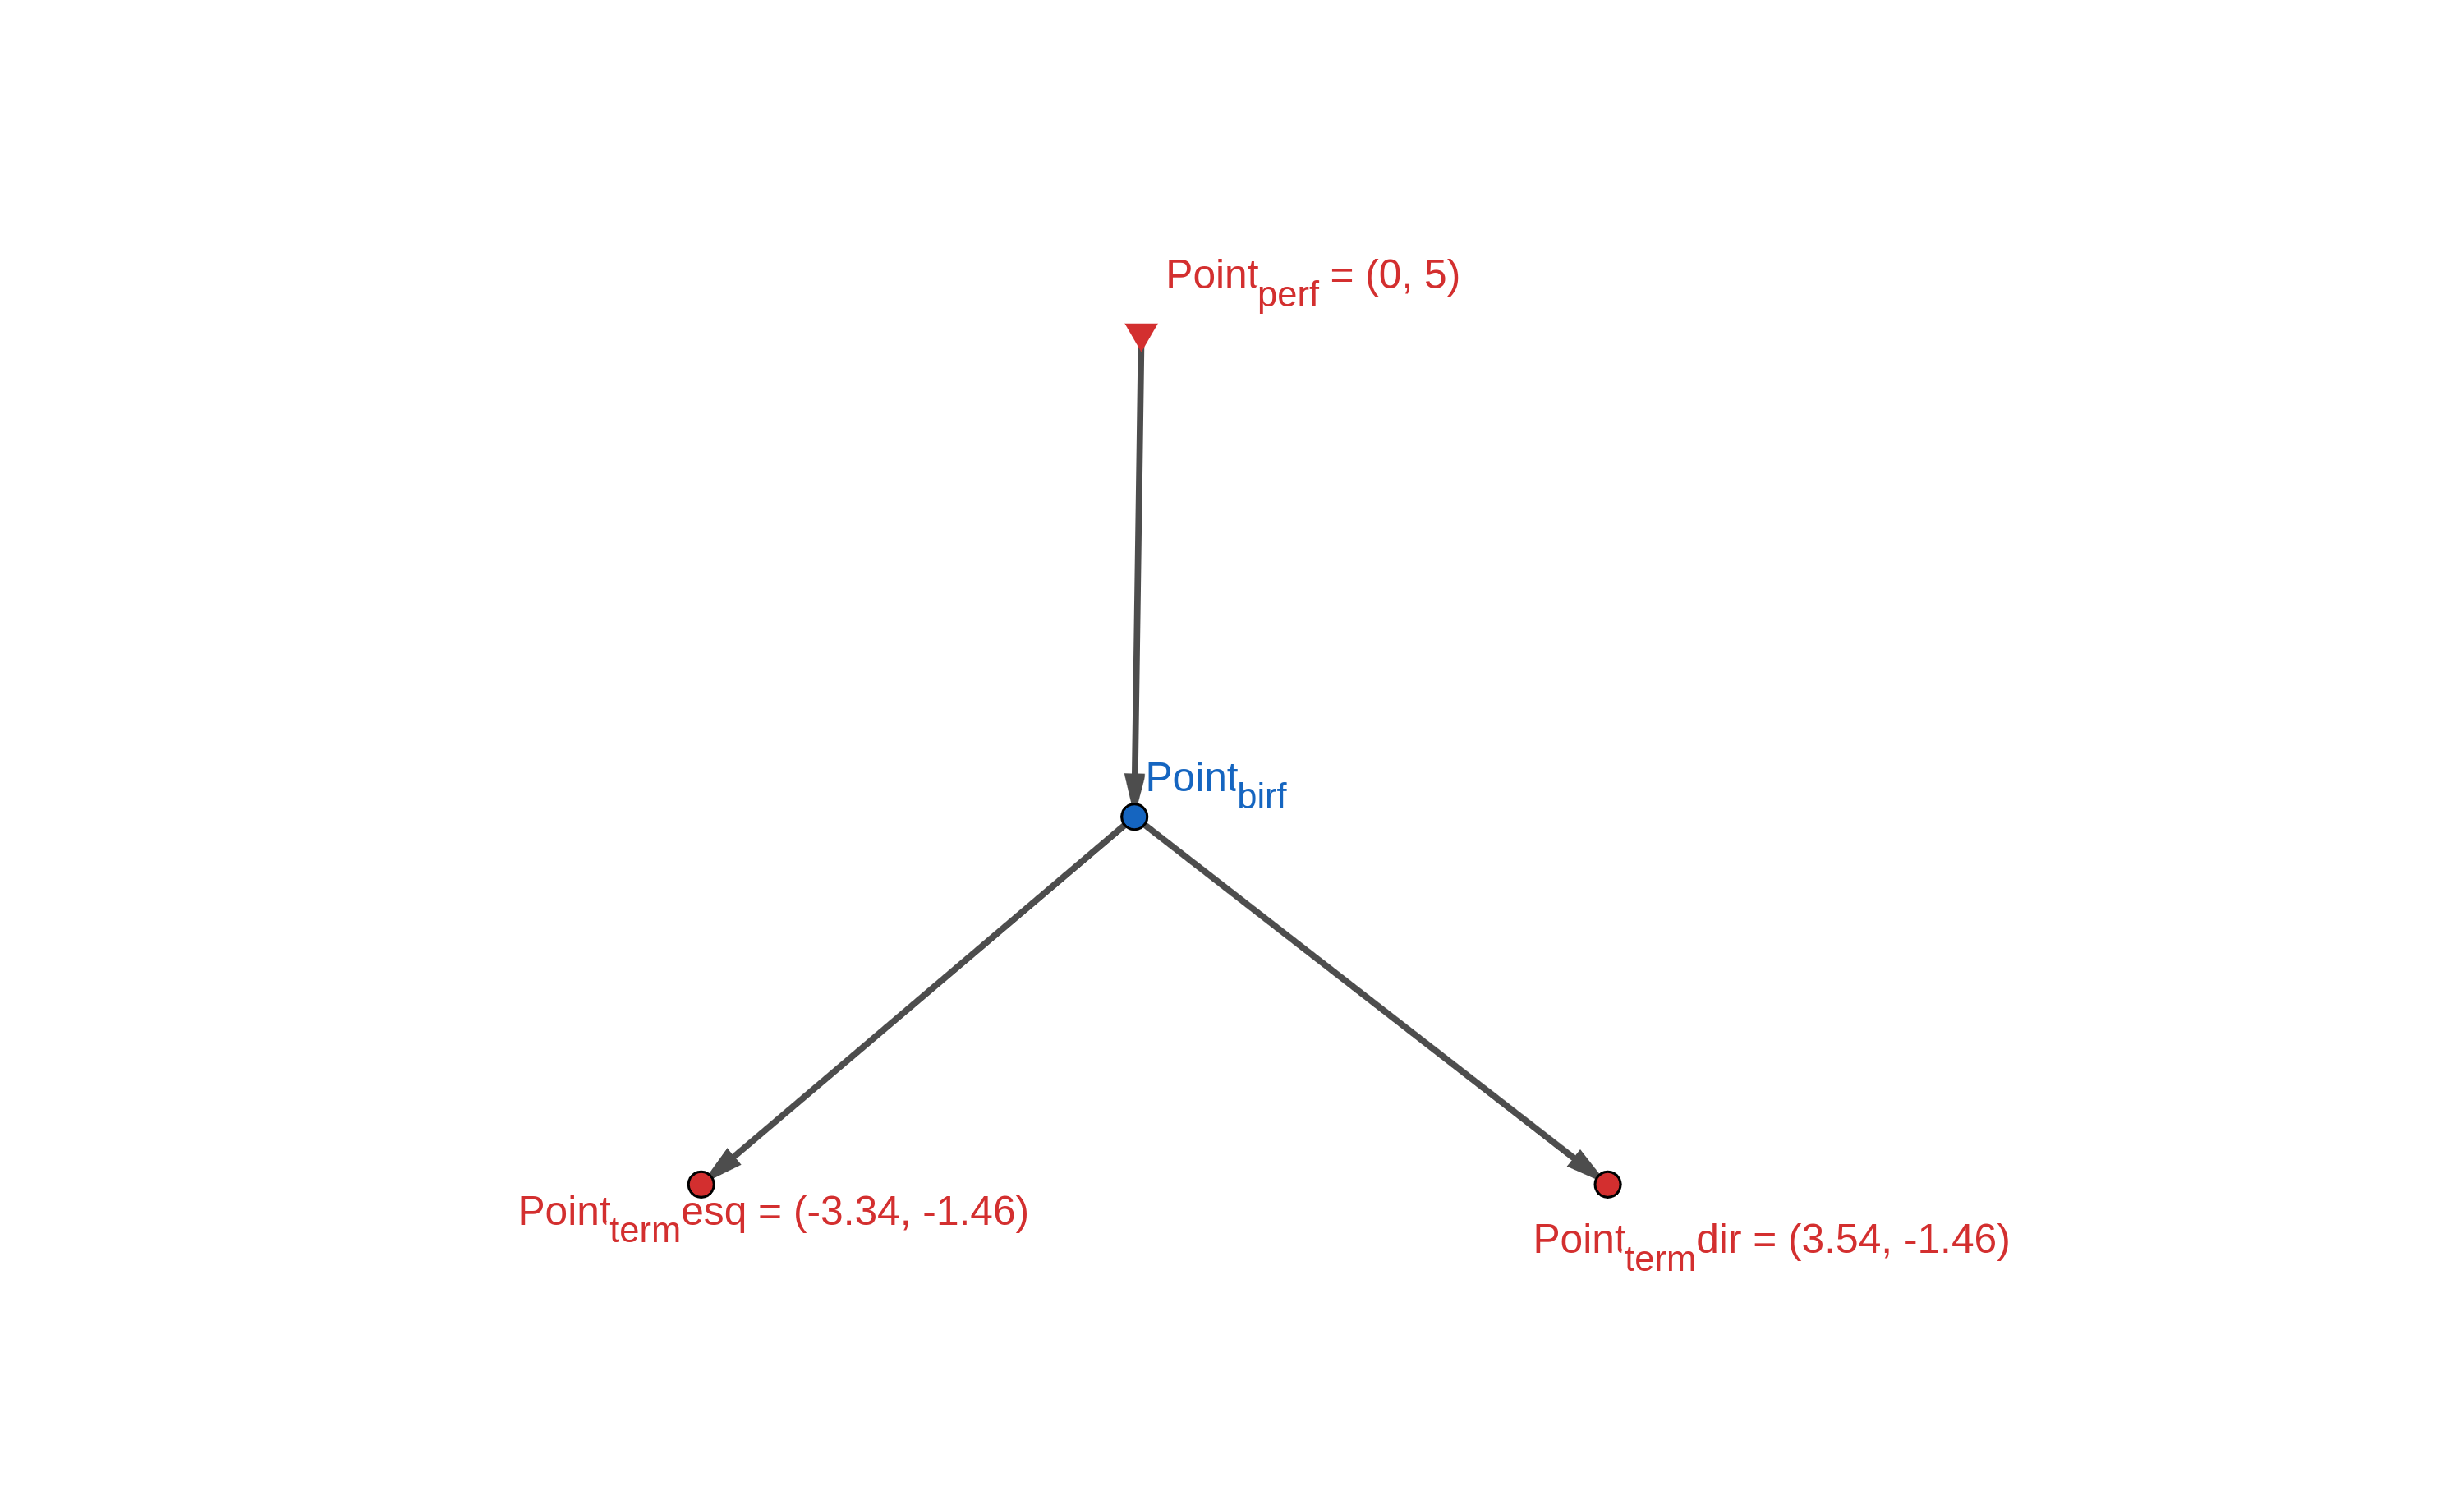

In [115]:
POINT_PERF = [0.00, 5.00]
POINT_TERM_ESQ = [-3.54, -1.46]
POINT_TERM_DIR = [3.54, -1.46]

X_MIN = min(POINT_PERF[0], POINT_TERM_ESQ[0], POINT_TERM_DIR[0])
X_MAX = max(POINT_PERF[0], POINT_TERM_ESQ[0], POINT_TERM_DIR[0])
Y_MIN = min(POINT_PERF[1], POINT_TERM_ESQ[1], POINT_TERM_DIR[1])
Y_MAX = max(POINT_PERF[1], POINT_TERM_ESQ[1], POINT_TERM_DIR[1])

-3.54 3.54 -1.46 5.0


Para auxiliar na busca do resultado ótimo é mister delimitar o espaço de busca. Para tal, será tomado como hipótese que o ponto ótimo para a bifurcação está dentro do triangulo formado pelos vértices $Point_{perf}$,  $Point_{term}esq$ e  $Point_{term}dir$.

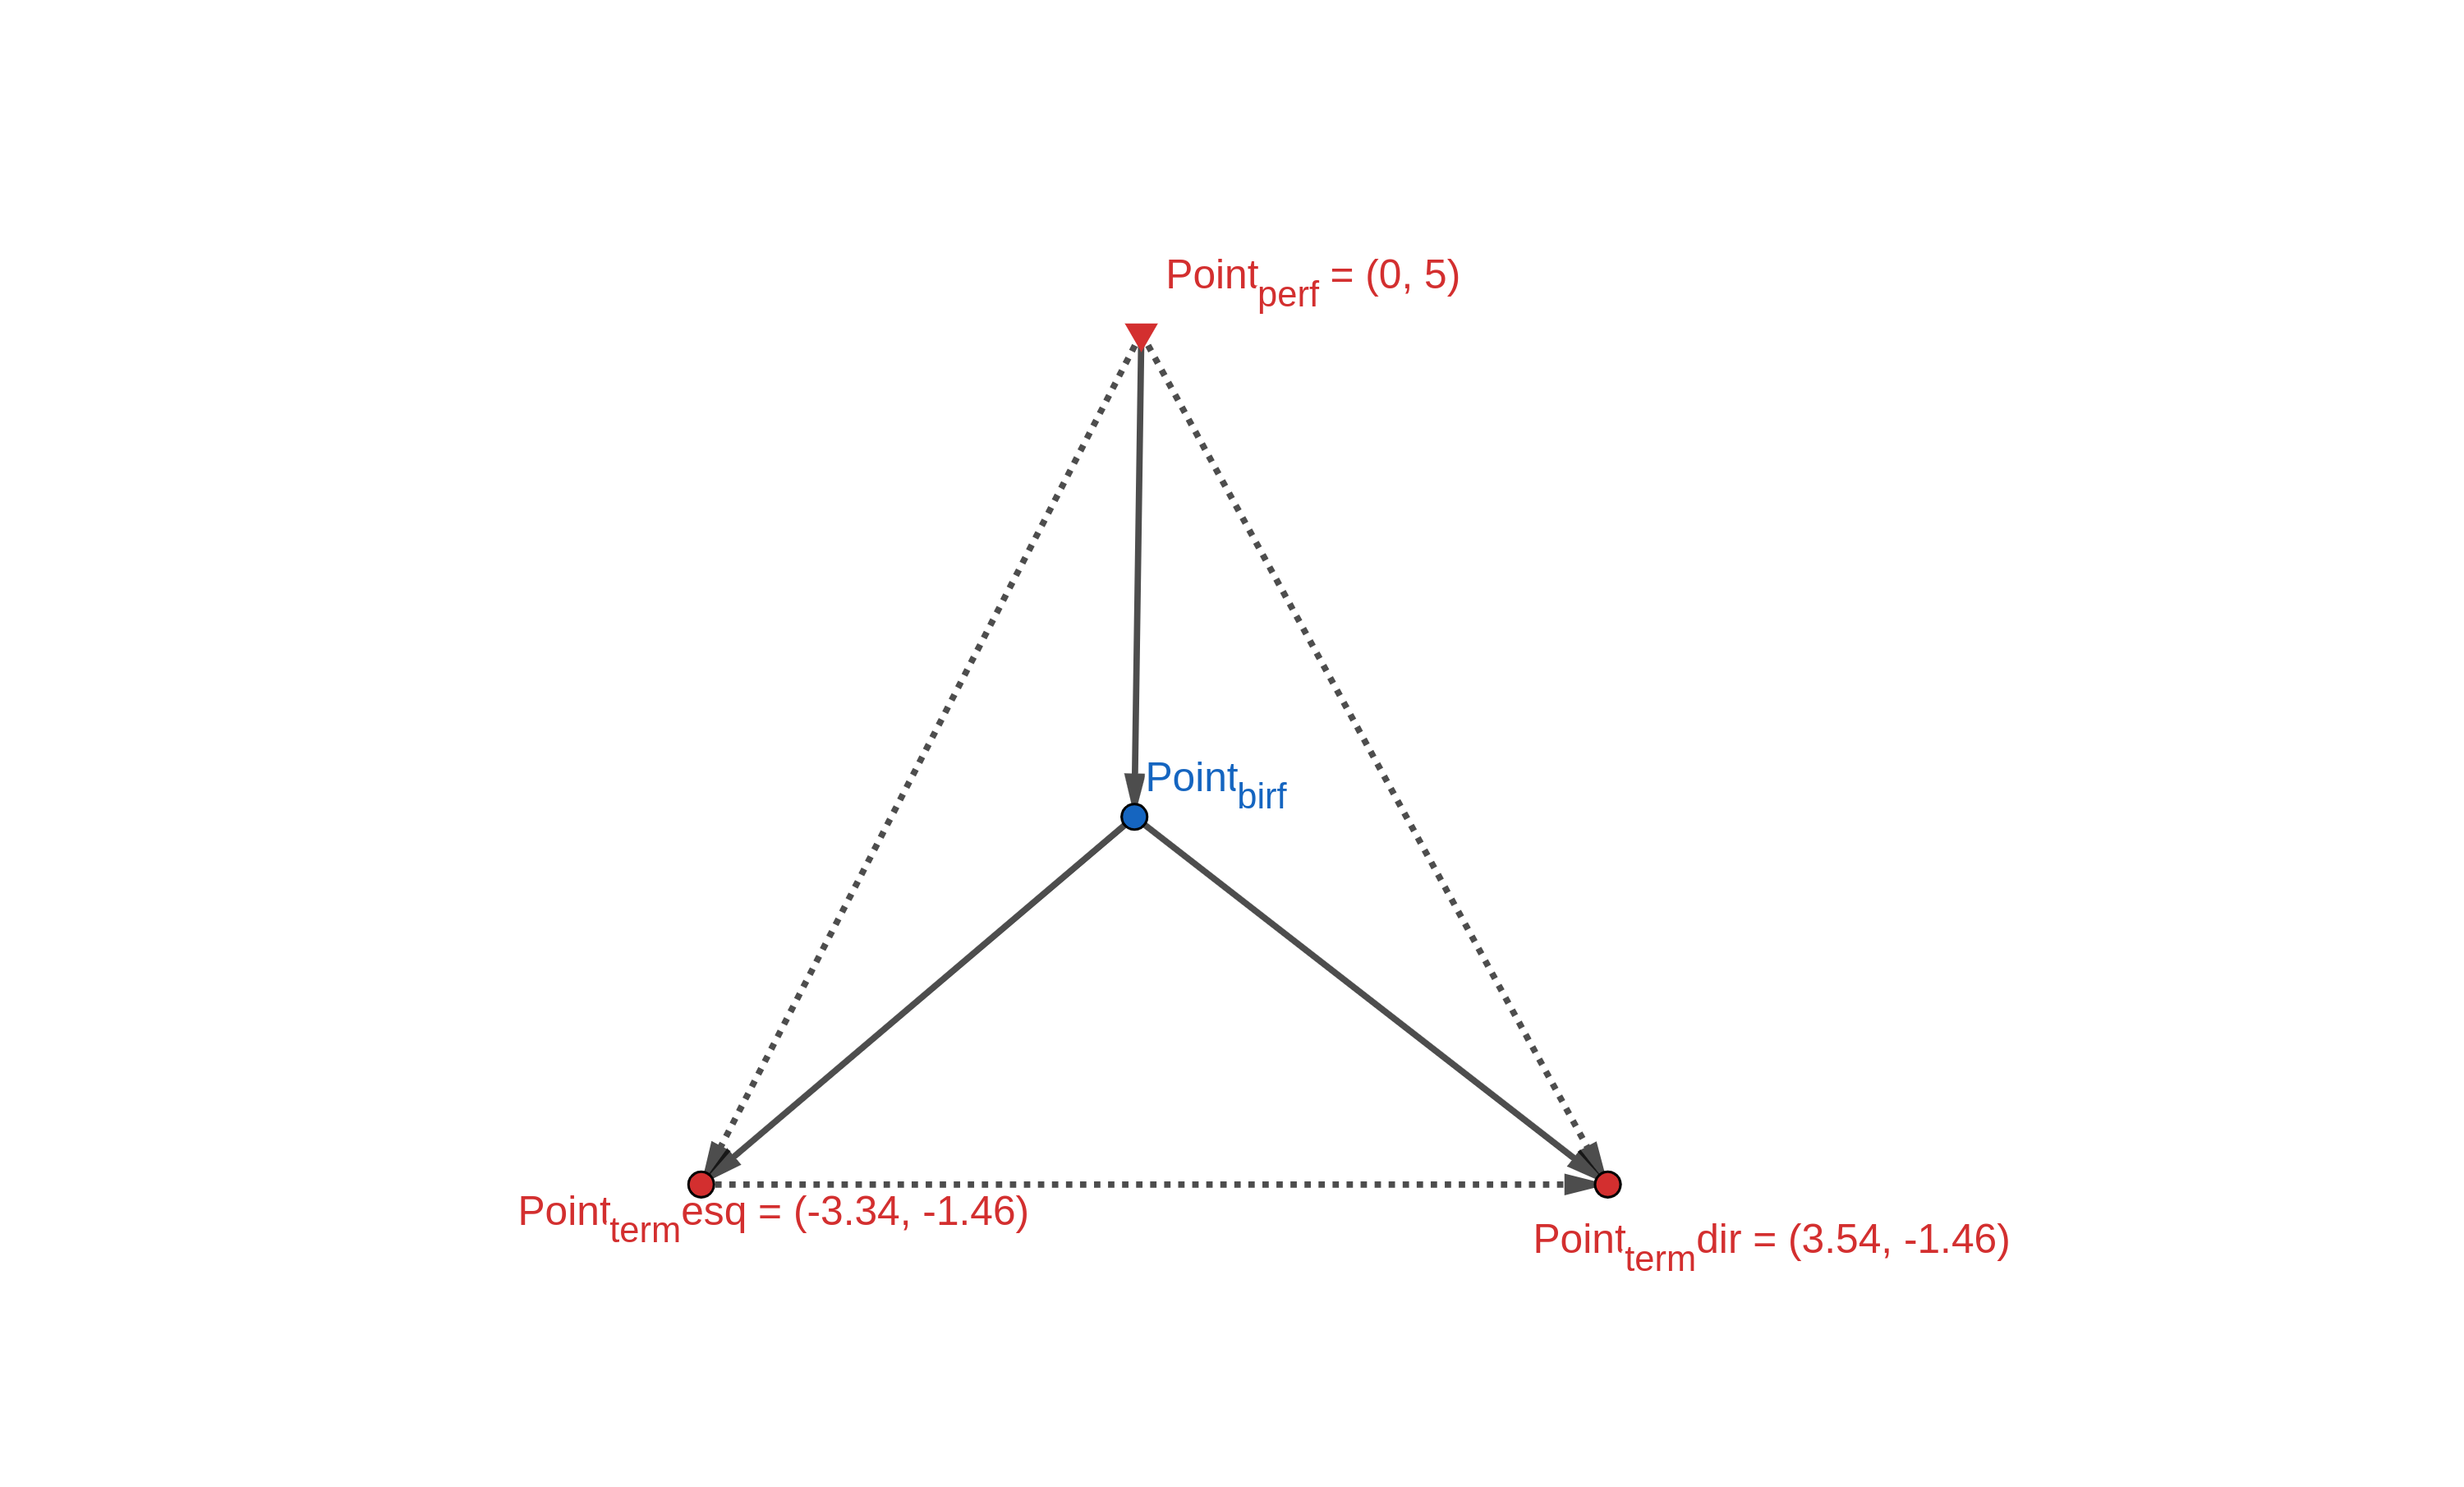

Para que isso ocorra a soma das áreas dos triangulos $(Point_{term}esq, Point_{term}dir, Point_{birf})$, $(Point_{term}esq, Point_{perf}, Point_{birf})$ e $(Point_{term}dir, Point_{perf}, Point_{birf})$ terá de ser igual a área do triangulo $( Point_{perf}, Point_{term}esq, Point_{term}dir)$.

In [116]:
def validaBirfucacao(pointBirf: list[float]) -> bool:

    if (pointBirf[0] < X_MIN or pointBirf[0] > X_MAX) or (pointBirf[1] < Y_MIN or pointBirf[1] > Y_MAX):
        return False

    def area_triangulo(a, b, c):
        return 0.5 * abs(a[0] * (b[1] - c[1]) +
                         b[0] * (c[1] - a[1]) +
                         c[0] * (a[1] - b[1]))

    area_original = area_triangulo(POINT_PERF, POINT_TERM_ESQ, POINT_TERM_DIR)

    area1 = area_triangulo(pointBirf, POINT_TERM_ESQ, POINT_TERM_DIR)
    area2 = area_triangulo(pointBirf, POINT_PERF, POINT_TERM_DIR)
    area3 = area_triangulo(pointBirf, POINT_TERM_ESQ, POINT_PERF)

    # Comparação com tolerância para evitar erros de ponto flutuante
    return math.isclose(area_original, (area1 + area2 + area3), rel_tol=1e-9)

Alem de definir os parametros estruturais, precisamos definir alguns parametros fisiologicos da árvore a ser modeladas. Dentro os parametro estão a pressão de perfusão e terminal $P_{perf} = 70 mmHg$ ou $9332,57Pa$ e $P_{term} = 30mmHg$ ou $3999,67Pa$, o fluxo $Q_{perf} = 0,2244L/min$ ou $3,74e^{-6}m³/s$, a viscosidade do sangue $ \eta = 3.6cP$ ou $0.0036Pa.s$ e o coeficiente de bifurcação $ \gamma = 3 $.

In [111]:
P_PERF = 9332.57
P_TERM = 3999.67
Q_PERF = 3.74e-6
VISCOSIDADE = 0.0036
GAMMA = 3

Dadas as equações do método CCO e os parâmetros fisiológicos e topológicos estabelecidos, podemos definir a seguinte função, que calculará e retornará o volume intravascular total da árvore para um ponto de bifurcação específico, fornecido como parâmetro.

In [120]:
def volumeTotal(ponto_birf: list[float], ponto_perf: list[float] = POINT_PERF, ponto_term_esq: list[float] = POINT_TERM_ESQ,
               ponto_term_dir: list[float] = POINT_TERM_DIR, pressaoDiff: float = (P_PERF - P_TERM),
               fluxo: float = Q_PERF, gamma: float = GAMMA, viscosidade: float = VISCOSIDADE) -> float:

    # Calcula os comprimentos e resistencias relativas
    segmento_pai = {}
    segmento_pai["comprimento"] = calcComprimento(ponto_perf, ponto_birf)
    segmento_pai["resistencia_relativa"] = calcResistenciaRelativa(segmento_pai["comprimento"], viscosidade)

    segmento_esq = {}
    segmento_esq["comprimento"] = calcComprimento(ponto_birf, ponto_term_esq)
    segmento_esq["resistencia_relativa"] = calcResistenciaRelativa(segmento_esq["comprimento"], viscosidade)

    segmento_dir = {}
    segmento_dir["comprimento"] = calcComprimento(ponto_birf, ponto_term_dir)
    segmento_dir["resistencia_relativa"] = calcResistenciaRelativa(segmento_dir["comprimento"], viscosidade)

    # Calcula os raios relativos e razão de birfurcação
    raio_relativo = calcRaioRelativo(segmento_esq["resistencia_relativa"], segmento_dir["resistencia_relativa"])
    razao_birf_esq = calcRazaoBirfucacao_esq(raio_relativo, gamma)
    razao_birf_dir = calcRazaoBirfucacao_dir(raio_relativo, gamma)

    # Calcula a resistencia relativa da sub arvore do segmento pai
    resistencia_relativa_sub = calcResistenciaRelativa_sub(segmento_pai["resistencia_relativa"], segmento_esq["resistencia_relativa"],
                                                           segmento_dir["resistencia_relativa"], razao_birf_esq, razao_birf_dir)
    # Calcula os raios
    segmento_pai["raio"] = calcRaio_pai(resistencia_relativa_sub, pressaoDiff, fluxo)
    segmento_esq["raio"] = calcRaio_esq(segmento_pai["raio"], razao_birf_esq)
    segmento_dir["raio"] = calcRaio_dir(segmento_pai["raio"], razao_birf_dir)

    segmentos = [segmento_pai, segmento_esq, segmento_dir]

    print(segmentos)

    # Calcula o Volume total
    return calcVolume(segmentos)

print(volumeTotal([0, 0]))

[{'comprimento': np.float64(5.0), 'resistencia_relativa': np.float64(0.0018334649444186344), 'raio': np.float64(0.0013580218318540013)}, {'comprimento': np.float64(3.829255802372048), 'resistencia_relativa': np.float64(0.0023940225451677673), 'raio': np.float64(0.0010778626422404116)}, {'comprimento': np.float64(3.829255802372048), 'resistencia_relativa': np.float64(0.0023940225451677673), 'raio': np.float64(0.0010778626422404116)}]


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

## 3.2 benchmark

## 3.2 Deap e configurações

# 4. Resultados


# 5. Conclusão

# Referências


[1]. Rudolf Karch, Friederike Neumann, Martin Neumann e Wolfgang Schreiner. “A three-dimensional model for arterial tree representation, generated by constrained constructive optimization”. Em: Computers in Biology and Medicine 29.1 (1999), pp. 19–38. issn: 0010-4825. doi: 10.1016/S0010- 4825(98)00045- 6. url: https://doi.org/10.1016/S0010-4825(98)00045-6.




[2].   Rafael Alves Bonfim Queiroz. “Construção automática de modelos de árvores circulatórias e suas aplicações em hemodinâmica computacional”. Portuguese. Acesso Aberto. Tese de Doutorado. Petrópolis, RJ, Brasil: Programa de Pós-Graduação em Modelagem Computacional, Laboratório Nacional de Computação Científica (LNCC), 2013. url: https://tede.lncc.br/handle/tede/170.

[3]. W. Schreiner e P.F. Buxbaum. “Computer-optimization of vascular trees”. Em: IEEE Transactions on Biomedical Engineering 40.5 (1993), pp. 482–491. doi: 10.1109/10.243413. url: https://doi.org/10.1109/10.243413.
